# (시도) Eearthquake
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연, 최규빈

### imports

In [1]:
import tqdm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

### load data and clean it

`-` load

In [4]:
df= pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')
df

,Date,Latitude,Longitude,Magnitude
0,01/02/1965,19.2460,145.6160,6.0
1,01/04/1965,1.8630,127.3520,5.8
2,01/05/1965,-20.5790,-173.9720,6.2
3,01/08/1965,-59.0760,-23.5570,5.8
4,01/09/1965,11.9380,126.4270,5.8
...,...,...,...,...
23407,12/28/2016,38.3917,-118.8941,5.6
23408,12/28/2016,38.3777,-118.8957,5.5
23409,12/28/2016,36.9179,140.4262,5.9
23410,12/29/2016,-9.0283,118.6639,6.3


`-` cleaning

In [5]:
df.Date[df.Date == '1975-02-23T02:58:41.000Z']

3378    1975-02-23T02:58:41.000Z
Name: Date, dtype: object

In [6]:
df.iloc[3378,0] = '02/03/1975'

In [7]:
df.Date[df.Date == '1985-04-28T02:53:41.530Z']

7512    1985-04-28T02:53:41.530Z
Name: Date, dtype: object

In [8]:
df.iloc[7512,0] = '04/28/1985'

In [9]:
df.Date[df.Date == '2011-03-13T02:23:34.520Z']

20650    2011-03-13T02:23:34.520Z
Name: Date, dtype: object

In [10]:
df.iloc[20650,0] = '03/13/2011'

In [11]:
df= df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).iloc[:,1:]
df

,Latitude,Longitude,Magnitude,Year
0,19.2460,145.6160,6.0,1965
1,1.8630,127.3520,5.8,1965
2,-20.5790,-173.9720,6.2,1965
3,-59.0760,-23.5570,5.8,1965
4,11.9380,126.4270,5.8,1965
...,...,...,...,...
23407,38.3917,-118.8941,5.6,2016
23408,38.3777,-118.8957,5.5,2016
23409,36.9179,140.4262,5.9,2016
23410,-9.0283,118.6639,6.3,2016


In [12]:
df.Year.unique()

array(['1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972',
       '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016'], dtype=object)

In [13]:
df.Year = df.Year.astype(np.float64)

### define class

In [14]:
class MooYaHo:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
#         nlst = self.df.groupby('Year').aggregate(len).Latitude.tolist()
#         nlst = [0]+np.cumsum(nlst).tolist()
#         beta_matrix = np.zeros([self.n,self.n])
#         for i in range(len(nlst)-1):
#             beta_matrix[nlst[i]:nlst[i+1],nlst[i]:nlst[i+1]] = beta
#         self.W = self.W * beta_matrix 
#     def _get_laplacian(self):
#         self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
#         self.lamb, self.Psi = np.linalg.eigh(self.L)
#         self.Lamb = np.diag(self.lamb)  

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')
        
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.3,
                        mapbox_style="stamen-terrain")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 1
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

### analysis

`-` make instance for analysis

In [57]:
moo=MooYaHo(df.query("Year == 2010"))

- 테스트용으로 2016년 자료만 수집

`-` get distance 

In [58]:
moo.get_distance()

100%|██████████| 560/560 [00:00<00:00, 1442.92it/s]


In [59]:
moo.D[moo.D>0].mean()

9018.167558845837

- 0이 아닌 거리의 평균은 8600정도?

(array([30652., 31054., 39626., 40054., 35368., 33600., 36004., 33382.,
        27164.,  6136.]),
 array([7.03001583e-01, 1.99343174e+03, 3.98616049e+03, 5.97888923e+03,
        7.97161797e+03, 9.96434671e+03, 1.19570755e+04, 1.39498042e+04,
        1.59425329e+04, 1.79352617e+04, 1.99279904e+04]),
 <BarContainer object of 10 artists>)

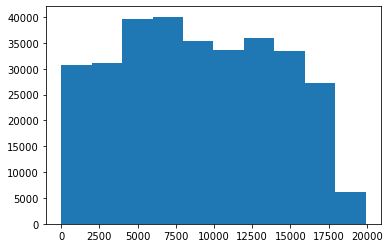

In [60]:
plt.hist(moo.D[moo.D>0])

- 히스토그램결과 -> 2500보다 거리가 작으면 거의 같은 지역이라고 봐도 무방할듯

`-` weight matrix

In [61]:
moo.get_weightmatrix(theta=(8647.92),kappa=2500) 

- 평균적으로 노드는 `np.exp(-(dist/8647)**2)=np.exp(-1)=0.36787944117144233` 정도의 연결강도를 가진다. 
- 거리가 2500이하이면 weight를 1로 설정한다. 

`-` fit

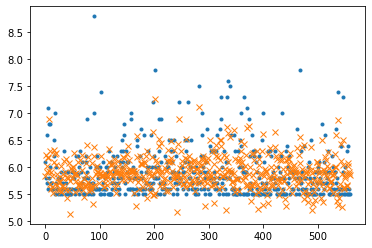

In [62]:
moo.fit(m=250)

`-` vis

In [70]:
#moo.vis(MagThresh=6.9,ResThresh=10) # <- 실행해봐요

- 전체자료는 underlying에 위치 
- 지진강도가 MagThresh 이상인 자료는 붉은점으로 시각화함 
- 이상치정도(우리가 제안하는 새로운 메져) ResThresh 이상인 자료는 파란점으로 시각화함 

### 한계점 (?)

`-` 시간효과를 따로 모형화하지는 않음 

---

In [37]:
pd.read_html('https://ko.wikipedia.org/wiki/%EC%A7%80%EC%A7%84_%EB%AA%A9%EB%A1%9D',encoding='utf-8')[0]

,순위,일자,장소,이름,사망자,규모,비고
0,1,1556년 1월 23일,중국 산시,산시 대지진,830000,8.3,NaN
1,2,1976년 7월 28일,중국 탕산,탕산지진,"255,000 (공식)",7.5,NaN
2,3,2010년 1월 12일,아이티,2010년 아이티 지진,"230,000 이상",7.0,NaN
3,4,2004년 12월 26일,인도네시아 수마트라섬,2004년 인도양 지진 해일,230210,9.1-9.3,NaN
4,5,1138년 10월 11일,시리아 알레포,1138년 알레포 지진,230000,8.5,NaN
5,6,1920년 12월 16일,중국 닝샤 - 간쑤,1920년 하이위안 지진,"200,000 - 240,000",7.8 또는 8.5,NaN
6,7,893년 3월 23일,이란 아르다빌,893년 아르다빌 지진,150000,NaN,NaN
7,8,1923년 9월 1일,일본 간토,간토 대지진,143000,7.9,NaN
8,9,1948년 10월 6일,투르크메니스탄 아시가바트,1948년 아시가바트 지진,110000,7.3,NaN


In [38]:
pd.read_html('https://ko.wikipedia.org/wiki/%EC%A7%80%EC%A7%84_%EB%AA%A9%EB%A1%9D',encoding='utf-8')[1]

,순위,일자,장소,이름,규모
0,1,1960년 5월 22일,칠레 발디비아,1960년 칠레 지진,9.4-9.6
1,2,1964년 3월 27일,미국 알래스카주 프린스윌리엄 만,1964년 알래스카 지진,9.2
2,3,2004년 12월 26일,인도네시아 수마트라섬,2004년 인도양 지진 해일,9.1-9.2
3,4,2011년 3월 11일,일본 산리쿠 해역,2011년 도호쿠 지방 태평양 앞바다 지진,9.1
4,5,1952년 11월 4일,소비에트 연방 캄차카반도,1952년 세베로쿠릴스크 지진,9.0
5,6 (공동),1707년 10월 28일,일본 난카이도,1707년 호에이 지진,8.8 (추정)
6,6 (공동),1833년 11월 25일,인도네시아(당시 네덜란드령 동인도 제도) 수마트라섬,1833년 수마트라 지진,8.8 (추정)
7,6 (공동),1906년 1월 31일,에콰도르-콜롬비아 국경 지대,1906년 에콰도르-콜롬비아 지진,8.8
8,6 (공동),2010년 2월 27일,칠레 마울레주 해역,2010년 칠레 지진,8.8


In [39]:
pd.read_html('https://ko.wikipedia.org/wiki/2016%EB%85%84_%EC%A7%80%EC%A7%84#cite_note-1',encoding='utf-8')[2]

,매그니튜드,2006년,2007년,2008년,2009년,2010년,2011년,2012년,2013년,2014년,2015년,2016년
0,8.0–9.9,2,4,0,1,1,1,2,2,1,1,0
1,7.0–7.9,9,14,12,16,23,19,14,17,11,18,16
2,6.0–6.9,142,178,167,144,151,187,117,123,143,127,130
3,5.0–5.9,1731,2090,1790,1920,2221,2486,1546,1454,1574,1412,1550
4,4.0–4.9,12861,12086,12306,6835,10140,13131,10957,11872,15816,13776,13699
5,합계,14746,14372,14277,8917,12539,15824,12637,13469,17545,15334,15395


2011년
- 진도 9 이상 일본 한 건, 

2016년
- 경주 지진 있던 해, 진도가 5.4 이상, 지도에는 없음.

1976년
- 중국 탕산 지진, 일어난 3곳 ( 2곳은 residual 1 이상)

2004년
- 인도 수마트라섬 지진, 9 이상인 점(red)과 residual 1이상인 점(blue)이 겹침
- 때때로 해구에 도달하는 지진에서 섭입판 경계면이 파열되어 1907년, 2004년, 2010년과 같은 대형 쓰나미가 발생한다. (https://ko.wikipedia.org/wiki/2022%EB%85%84_%EC%88%98%EB%A7%88%ED%8A%B8%EB%9D%BC_%EC%A7%80%EC%A7%84)